In [1]:
import numpy as np
import nibabel as nb
import sys
import os
import yaml
import matplotlib.pyplot as plt
import gurobipy as gp
%matplotlib widget 
from mpl_toolkits.mplot3d import Axes3D

sys.path.append("/home/mehdii/projects/def-vidalthi/mehdii/3DPU_Plateau_Problem")
from src.PU3D_project._3DLoops._3dpu_using_dfs import *
from src.PU3D_project.Block_edges.block_edges import *
import src.PU3D_project.ROMEO.romeo.utils as romeo
import src.PU3D_project.MIP_constraints.Python as MIP

import src.PU3D_project.utils as utils

## Create a data set or extract it

In [2]:
config = yaml.safe_load(open("/home/mehdii/projects/def-vidalthi/mehdii/3DPU_Plateau_Problem/paths.yaml"))

In [3]:
path_data = config["paths"]["phase_data"]
data_brut = nb.load(path_data)
t = 1
phase = data_brut.get_fdata()[:,:,:,t]

In [58]:
i1,i2,j1,j2,k1,k2 = 0, 100, 0, 100, 0, 20
phase = phase[i1:i2,j1:j2,k1:k2]

# Use our Method on it

*Detect the loops*

In [20]:
C = Resiuals(phase)
C.create_loops(separate=True,num_workers = 5)

100%|██████████| 414/414 [00:00<00:00, 2178722.53it/s]


18
now separating the open paths


100%|██████████| 753/753 [00:00<00:00, 21635.67it/s]


*Fill in the loops*

In [21]:
Blocked_edges_cycles_init = []
for cycle in tqdm(C.cycles):
    cycle = [utils.transform_res_to_point(C.mapping[i]) for i in cycle]
    boundary = PointList()
    boundary.points = cycle
    M = Final_minimization(boundary,10*len(cycle))
    M.create_quadrilaterals()
    M.split_quadrilateral()
    M.canonic_representation_from_mesh()
    M.clean_triangles()
    M.fill_edges()
    B = Block_edges(M.triangles,M.mapping)
    B.block_all_the_edges()
    Blocked_edges_cycles_init.append(B.blocked_edges)

100%|██████████| 563/563 [01:42<00:00,  5.47it/s]


In [59]:
with open('Blocked_edges_cycles_init.pkl', 'rb') as f:
    Blocked_edges_cycles_init = pickle.load(f)

In [60]:
MIP_blocked_edges = []
for blcked_edges in tqdm(Blocked_edges_cycles_init):
    try:
        MIP_blocked_edges.append(MIP.minimize_edges_MIP(blcked_edges,time_limit=15, num_threads=5))
    except gp.GurobiError as e:
        MIP_blocked_edges.append(blcked_edges)
        print(f'GurobiError: {e}')
        continue

  7%|▋         | 169/2507 [00:10<00:40, 58.33it/s]

GurobiError: Model too large for size-limited license; visit https://gurobi.com/unrestricted for more information


 32%|███▏      | 814/2507 [01:15<01:19, 21.21it/s]

GurobiError: Model too large for size-limited license; visit https://gurobi.com/unrestricted for more information


 48%|████▊     | 1207/2507 [07:46<38:57,  1.80s/it]  

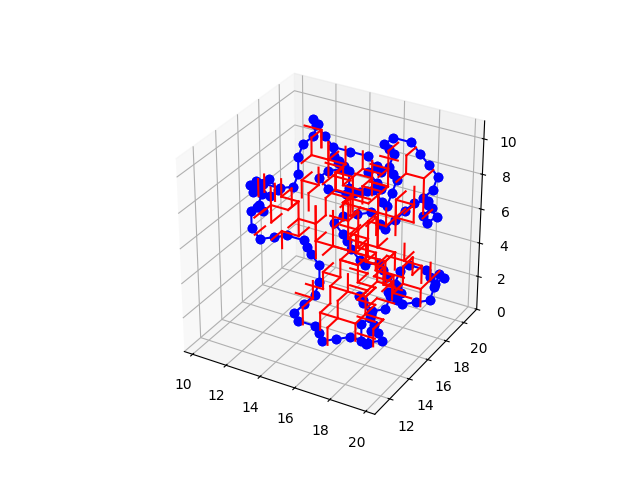

In [46]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect('equal')


ind = C.cycles.index(max(C.cycles,key=lambda x: len(x)))
cycle = C.cycles[ind]
Blocked_edges = MIP_blocked_edges[ind]

X = []
Y = []
Z = []

for i in range(len(cycle)-1):
    edgeX = [utils.transform_res_to_point(C.mapping[cycle[i]])[0], utils.transform_res_to_point(C.mapping[cycle[(i+1)]])[0]]
    edgeY = [utils.transform_res_to_point(C.mapping[cycle[i]])[1], utils.transform_res_to_point(C.mapping[cycle[(i+1)]])[1]]
    edgeZ = [utils.transform_res_to_point(C.mapping[cycle[i]])[2], utils.transform_res_to_point(C.mapping[cycle[(i+1)]])[2]]
    ax.plot(edgeX, edgeY, edgeZ, color='b',marker='o')
    X.extend(edgeX)
    Y.extend(edgeY)
    Z.extend(edgeZ)

for edge in Blocked_edges:
    edgeX = [edge[0][0], edge[1][0]]
    edgeY = [edge[0][1], edge[1][1]]
    edgeZ = [edge[0][2], edge[1][2]]
    ax.plot(edgeX, edgeY, edgeZ, color='r')
    



X = np.array(X)
Y = np.array(Y)
Z = np.array(Z)

max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max() / 2.0 

mid_x = (X.max()+X.min()) * 0.5
mid_y = (Y.max()+Y.min()) * 0.5
mid_z = (Z.max()+Z.min()) * 0.5
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

plt.show()



In [48]:
sum([len(edges) for edges in Blocked_edges_cycles_init]), sum([len(edges) for edges in MIP_blocked_edges])

(4346, 2113)

## Use Romeo on it

In [56]:
unwrapp_romeo = romeo.unwrapp_phase(phase,Blocked_edges_cycles_init+MIP_blocked_edges)
phase.shape


  0%|          | 0/35875 [00:00<?, ?it/s]

100%|██████████| 35875/35875 [00:00<00:00, 664467.49it/s]


(25, 25, 20)

In [53]:
N_romeo = utils.compute_absolute_phase_gradients(unwrapp_romeo,phase)


In [54]:
N_romeo

13219

563

## Scikit learn usage

In [ ]:
from skimage.restoration import unwrap_phase

In [ ]:
unwrapp_scikit = unwrap_phase(phase)

In [ ]:
N_scikit = utils.compute_absolute_phase_gradients(unwrapp_scikit,phase)
N_scikit

157930